In [1]:
import scvelo as scv
import scanpy as sc
from sklearn.metrics import pairwise_distances
import numpy as np
from sklearn.model_selection import StratifiedKFold
from pathlib import Path
import utils
import importlib
import pandas as pd
import anndata as ad
import mygene
importlib.reload(utils)
import gc

In [2]:
DATA_DIR = Path("/root/autodl-tmp/dataset") 
DATASET = "FUCCI_RPE1"
K_FOLD = 3
CLUSTER_KEY = 'dtime'
SEED = 1234

In [3]:
(DATA_DIR / DATASET / "raw").mkdir(parents=True, exist_ok=True)
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "processed").mkdir(parents=True, exist_ok=True)

## Load the full dataset

In [4]:
adata = sc.read_h5ad(DATA_DIR / DATASET / "raw" / f"{DATASET}.h5ad")

In [5]:
adata = adata[adata.obs["labeling_time"] != "dmso", :]
adata.obs['time'] = adata.obs['labeling_time'].astype(float)
adata = adata[adata.obs['experiment'] == "Pulse", :].copy()
adata.layers["unspliced"] = adata.layers["unlabeled_unspliced"] + adata.layers["labeled_unspliced"]
adata.layers["spliced"] = adata.layers["unlabeled_spliced"] + adata.layers["labeled_spliced"]
adata.obs["pseudo_clusters"] = pd.cut(adata.obs["cell_cycle_position"], bins=30, labels=False).astype(str).astype("category")
adata.obs["pseudo_clusters_equal_size"] = pd.qcut(adata.obs["cell_cycle_position"], q=30, labels=False)
adata.obs["pseudo_clusters_equal_size_num"] = adata.obs["pseudo_clusters_equal_size"].astype(float)
adata.obs["cell_cycle_rad"] = adata.obs["cell_cycle_position"] / adata.obs["cell_cycle_position"].max() * 2 * np.pi
adata.obs["dtime"] = pd.cut(adata.obs["cell_cycle_position"], bins=5, labels=False).astype(str).astype("category")
adata

AnnData object with n_obs × n_vars = 2793 × 11848
    obs: 'experiment', 'labeling_time', 'plate_id', 'well_id', 'cell_cycle_position', 'RFP_log10_corrected', 'GFP_log10_corrected', 'time', 'pseudo_clusters', 'pseudo_clusters_equal_size', 'pseudo_clusters_equal_size_num', 'cell_cycle_rad', 'dtime'
    layers: 'labeled_spliced', 'labeled_unspliced', 'new', 'total', 'unlabeled_spliced', 'unlabeled_unspliced', 'unspliced', 'spliced'

## Split the data

In [6]:
sub_adata_lst = utils.split_anndata_stratified(adata, n_splits=K_FOLD, cluster_key="dtime")

## Preprocessing each sub adata

In [7]:
for i in range(K_FOLD):
    sub_adata = sub_adata_lst[i].copy()
    sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
    sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
    scv.pp.filter_and_normalize(sub_adata, min_shared_counts=20, n_top_genes=2000)
    if sub_adata.n_vars < 2000:
        sc.pp.highly_variable_genes(sub_adata, n_top_genes=sub_adata.n_vars, subset=True)
    if 'X_pca' in sub_adata.obsm:
        del sub_adata.obsm['X_pca']
    if 'X_pca' in sub_adata.obsm:
        del sub_adata.obsm['X_pca']
    if 'pca' in sub_adata.uns:
        del sub_adata.uns['pca']
    if "neighbors" in sub_adata.uns.keys():
        del sub_adata.uns['neighbors']
    scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
    utils.fill_in_neighbors_indices(sub_adata)
    sc.tl.umap(sub_adata, random_state=SEED)
    sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
    sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
    if SAVE_DATA:
        sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_{i}.h5ad")
    del sub_adata
    gc.collect()

Filtered out 6250 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_20824/1023988249.py:16: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be remov

computing neighbors
    finished (0:00:06) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 6304 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_20824/1023988249.py:16: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be remov

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
Filtered out 6245 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_20824/1023988249.py:16: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be remov

computing neighbors
    finished (0:00:02) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


Filtered out 4596 genes that are detected 20 counts (shared).
Normalized count data: X, spliced, unspliced.
Extracted 2000 highly variable genes.
Logarithmized X.


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/utils.py:705: DeprecationWarning: `log1p` is deprecated since scVelo v0.3.0 and will be removed in a future version. Please use `log1p` from `scanpy.pp` instead.
  log1p(adata)
/tmp/ipykernel_20824/806162408.py:15: DeprecationWarning: Automatic neighbor calculation is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors first with Scanpy.
  scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/moments.py:71: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  neighbors(
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be remove

computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:01) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)


/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])
/root/autodl-tmp/conda/envs/velo/lib/python3.10/site-packages/scvelo/plotting/utils.py:68: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  return isinstance(c, str) and c in data.obs.keys() and cat(data.obs[c])


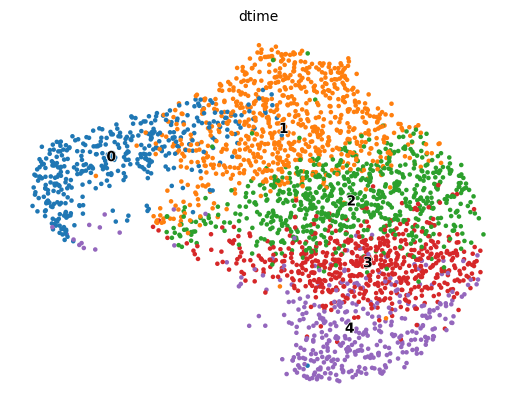

In [8]:
sub_adata = adata.copy()
sub_adata.layers['raw_spliced'] = sub_adata.layers['spliced']
sub_adata.layers['raw_unspliced'] = sub_adata.layers['unspliced']
scv.pp.filter_and_normalize(sub_adata, min_shared_counts=20, n_top_genes=2000)
if sub_adata.n_vars < 2000:
    sc.pp.highly_variable_genes(sub_adata, n_top_genes=sub_adata.n_vars, subset=True)
if 'X_pca' in sub_adata.obsm:
    del sub_adata.obsm['X_pca']
if 'X_pca' in sub_adata.obsm:
    del sub_adata.obsm['X_pca']
if 'pca' in sub_adata.uns:
    del sub_adata.uns['pca']
if "neighbors" in sub_adata.uns.keys():
    del sub_adata.uns['neighbors']
scv.pp.moments(sub_adata, n_neighbors=30, n_pcs=30)
utils.fill_in_neighbors_indices(sub_adata)
sc.tl.umap(sub_adata, random_state=SEED)
sub_adata.obs['u_lib_size_raw'] = sub_adata.layers['raw_unspliced'].toarray().sum(-1) 
sub_adata.obs['s_lib_size_raw'] = sub_adata.layers['raw_spliced'].toarray().sum(-1)
sub_adata.write_h5ad(DATA_DIR / DATASET / "processed" / f"adata_preprocessed_full.h5ad")
scv.pl.umap(sub_adata,color = 'dtime')